# Chapter 9. Extensions

Compute and plot the numerical results of Section 9.2. The commented code is in charge of loading simulation results that might be added later.

## Package imports and global variable definitions

In [1]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [2]:
# uncomment this line if you prefer dynamic matplotlib plots
# %matplotlib notebook

# change the default figure size
# pylab.rcParams['figure.figsize'] = (10.0, 6.0)
pylab.rcParams['legend.fontsize'] = 12

In [3]:
# useful in the function multi_dispatcher_dynamic
from scipy import special

In [4]:
# global variables
ρρ = linspace(4., 0, 50, endpoint=False)
I = 10
μ = 1.

## Function definitions

All numerical results are for two dispatchers only. Incoming jobs have no assignment constraints, so that they are only rejected if their dispatcher is empty of tokens.

### Single dispatcher

Compute the normalization constant in a cluster with a single dispatcher.

In [5]:
def single_dispatcher_normalization(l, μ, ν):
    # parameters
    I = len(l)
    cuml = zeros(I, dtype=int)
    cuml[1:] = cumsum(l[:-1])
    
    # initialization: π_0
    π = ones(1, dtype=float64)
    
    for i in range(I):
        # recursion:  derive π_{i+1} from π_i
        
        # compute p_{i+1}
        p = ones(l[i] + 1, dtype=float64)
        p[1:] = cumprod(μ[i] / (ν * arange(1, l[i]+1)), dtype=float64)
        
        # make the outer product of π_i with p_{i+1}
        π = outer(π, p[::-1])
        
        # multiply each coefficient by t! / s!
        for s in range(cuml[i] + 1):
            quotient = ones(l[i] + 1, dtype=float64)
            quotient[1:] = cumprod(s + arange(1, l[i] + 1), dtype=float64)
            π[s] *= quotient[::-1]
        
        # sum over the (anti)diagonals
        π = [trace(π, n) for n in range(l[i], -cuml[i] - 1, -1)]
    
    return 1. / sum(π)

### Multiple dispatchers with a static routing

In [6]:
def multi_dispatcher_static_normalization(l, α, β):
    I = len(l)
    maxl = max(l)
    cuml = cumsum(l)
    
    αs = ones(maxl + 1, dtype=float64)
    αs[1:] = cumprod(α / arange(1, maxl + 1))
    
    βt = ones(maxl + 1, dtype=float64)
    βt[1:] = cumprod(β / arange(1, maxl + 1))
    
    # i = 0
    oldπ = outer(α**arange(l[0] + 1), β**arange(l[0] + 1)) * (tri(l[0] + 1)[::-1])
    
    # i > 0
    for i in range(1, I):
        π = zeros((cuml[i] + 1, cuml[i] + 1), dtype=float64)
        
        for ps in range(cuml[i-1] + 1):
            for pt in range(cuml[i-1] - ps + 1):
                prods = float64(1.)
                for s in range(ps, ps + l[i] + 1):
                    prodt = float64(1.)
                    for t in range(pt, pt + l[i] - (s - ps) + 1):
                        π[s,t] += oldπ[ps, pt] * αs[s-ps] * βt[t-pt] * prods * prodt
                        prodt *= (t + 1)
                    prods *= (s + 1)
        
        oldπ = copy(π)
    
    return sum(sum(π))

In [7]:
def multi_dispatcher_static_loss(I, l, α1, p1, μ, ρρ):
    ll = l * ones(I, dtype=int)
    return [ (
        (1 - α1) / single_dispatcher_normalization(ll, p1 * μ * ones(I), α1 * I * μ * ρ)
        + α1 / single_dispatcher_normalization(ll, (1 - p1) * μ * ones(I), (1 - α1) * I * μ * ρ)
    ) / multi_dispatcher_static_normalization(ll, p1 / (α1 * I * ρ), (1 - p1) / ((1 - α1) * I * ρ)) for ρ in ρρ ]

### Multple dispatchers with a dynamic routing

In [8]:
def multi_dispatcher_dynamic_normalization(I, l, α, β):
    q = l // 2
    
    αs = ones(q + 1, dtype=float64)
    αs[1:] = cumprod(α / arange(1, q + 1))
    
    βt = ones(q + 1, dtype=float64)
    βt[1:] = cumprod(β / arange(1, q + 1))
    
    coeff = ones((q + 1, q + 1))
    for y in range(q + 1):
        for z in range(q + 1):
            coeff[y,z] = special.binom(l - y - z, q - y)
    
    # i = 0
    oldπ = outer(α**arange(l + 1), β**arange(l + 1)) * (tri(l + 1)[::-1])
    oldπ = oldπ[:q + 1,:q + 1] * coeff
    
    # i > 0
    for i in range(1, I):
        π = zeros((q * (i + 1) + 1, q * (i + 1) + 1), dtype=float64)
        
        for ps in range(q * i + 1):
            for pt in range(min(q * i, l * i - ps) + 1):
                prods = float64(1.)
                for s in range(ps, ps + q + 1):
                    prodt = float64(1.)
                    for t in range(pt, pt + min(q, l - (s - ps)) + 1):
                        π[s,t] += (oldπ[ps,pt] * αs[s - ps] * βt[t - pt]
                                   * prods * prodt * coeff[s - ps,t - pt])
                        prodt *= (t+1)
                    prods *= (s+1)
        
        oldπ = copy(π)
    
    return sum(sum(π))

In [9]:
def multi_dispatcher_dynamic_loss(I, l, α1, μ, ρρ):
    return [ (
    (1 - α1) * multi_dispatcher_dynamic_normalization(I, l, 1. / (α1 * I * ρ), 0.)
    + α1 * multi_dispatcher_dynamic_normalization(I, l, 0., 1. / ((1 - α1) * I * ρ))
) / multi_dispatcher_dynamic_normalization(I, l, 1. / (α1 * I * ρ), 1. / ((1 - α1) * I * ρ)) for ρ in ρρ ]

## Numerical results

### Balanced arrivals

In [10]:
# parameters
ll = [2, 4, 6]
α1 = .5 # proportion of arrivals at dispatcher 1
p1 = .5 # routing probabilities of tokens to dispatcher 1

In [11]:
static = [multi_dispatcher_static_loss(I, l, α1, p1, μ, ρρ) for l in ll]

In [12]:
dynamic = [multi_dispatcher_dynamic_loss(I, l, α1, μ, ρρ) for l in ll]

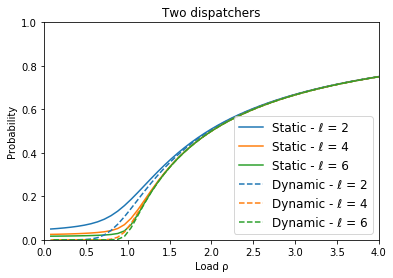

In [13]:
# plot
for i,l in enumerate(ll):
    plot(ρρ, static[i], label = "Static - ℓ = " + str(l))

for i,l in enumerate(ll):
    plot(ρρ, dynamic[i], '--', color = 'C'+str(i), label = "Dynamic - ℓ = " + str(l))

#for i,l in enumerate(ll):
#    ρρρ, exp_blocking \
#    = loadtxt('data/dispatchers' + str(l) + '-balanced-blocking', delimiter='\t', unpack=True)
#    plot(ρρρ, exp_blocking, color = 'C' + str(i), linestyle="None", marker="x", label="Static - ℓ = " + str(l))

#for i,l in enumerate(ll):
#    ρρρ, exp_blocking \
#    = loadtxt('data/baf' + str(l) + '-balanced-blocking', delimiter='\t', unpack=True)
#    plot(ρρρ, exp_blocking, color = 'C' + str(i), linestyle="None", marker="+", label="Dynamic - ℓ = " + str(l))

xlim(0,4); ylim(0,1)
legend(loc=4); title("Two dispatchers")
xlabel("Load ρ"); ylabel("Probability")
show()

### Imbalanced arrivals

In [14]:
# parameters
ll = [2, 4, 6]
α1 = .8 # proportion of arrivals at dispatcher 1

In [15]:
p1 = .5
uniform_static = [multi_dispatcher_static_loss(I, l, α1, p1, μ, ρρ) for l in ll]

In [16]:
p1 = α1
best_static = [multi_dispatcher_static_loss(I, l, α1, p1, μ, ρρ) for l in ll]

In [17]:
dynamic = [multi_dispatcher_dynamic_loss(I, l, α1, μ, ρρ) for l in ll]

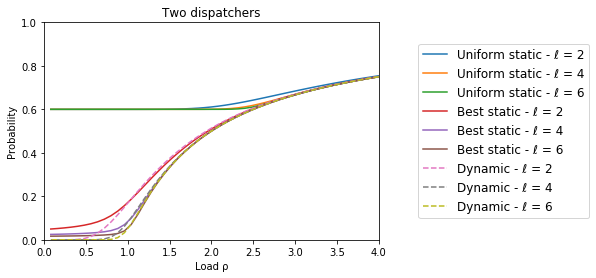

In [18]:
# plot
for i,l in enumerate(ll):
    plot(ρρ, uniform_static[i], label = "Uniform static - ℓ = " + str(l))
    
for i,l in enumerate(ll):
    plot(ρρ, best_static[i], label = "Best static - ℓ = " + str(l))

for i,l in enumerate(ll):
    plot(ρρ, dynamic[i], '--', label = "Dynamic - ℓ = " + str(l))

#for i,l in enumerate(ll):
#    ρρρ, exp_blocking \
#    = loadtxt('data/dispatchers' + str(l) + '-imbalanced-blocking', delimiter='\t', unpack=True)
#    plot(ρρρ, exp_blocking, color = 'C' + str(i), linestyle="None", marker="x", label="Static - ℓ = " + str(l))

#for i,l in enumerate(ll):
#    ρρρ, exp_blocking \
#    = loadtxt('data/baf' + str(l) + '-imbalanced-blocking', delimiter='\t', unpack=True)
#    plot(ρρρ, exp_blocking, color = 'C' + str(i), linestyle="None", marker="+", label="Dynamic - ℓ = " + str(l))

xlim(0,4); ylim(0,1)
legend(loc=6, bbox_to_anchor=(1.1, .5)); title("Two dispatchers")
xlabel("Load ρ"); ylabel("Probability")
show()

### Homogeneous

In [19]:
# parameters
l = 6
α1 = .5 # proportion of arrivals at dispatcher 1

In [20]:
p1 = α1
static = multi_dispatcher_static_loss(I, l, α1, p1, μ, ρρ)

In [21]:
dynamic = multi_dispatcher_dynamic_loss(I, l, α1, μ, ρρ)

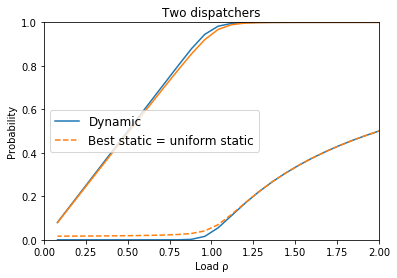

In [22]:
# plot
plot(ρρ, dynamic, color = 'C0', label = "Dynamic")
plot(ρρ, ρρ * [1. - β for β in dynamic], color = 'C0')
plot(ρρ, static, '--', color = 'C1', label = "Best static = uniform static")
plot(ρρ, ρρ * [1. - β for β in static], color = 'C1')

#ρρρ, exp_blocking \
#= loadtxt('data/dispatchers' + str(l) + '-homo-dynamic-blocking', delimiter='\t', unpack=True)
#plot(ρρρ, exp_blocking, color = 'C0', linestyle="None", marker="+", label="Dynamic")

#ρρρ, exp_blocking \
#= loadtxt('data/dispatchers' + str(l) + '-homo-static-blocking', delimiter='\t', unpack=True)
#plot(ρρρ, exp_blocking, color = 'C1', linestyle="None", marker="x", label="Best static")

xlim(0,2); ylim(0,1)
legend(loc='best'); title("Two dispatchers")
xlabel("Load ρ"); ylabel("Probability")
show()

### Heterogeneous

In [23]:
# parameters
l = 6
α1 = .8 # proportion of arrivals at dispatcher 1

In [24]:
p1 = .5
uniform_static = multi_dispatcher_static_loss(I, l, α1, p1, μ, ρρ)

In [25]:
p1 = α1
best_static = multi_dispatcher_static_loss(I, l, α1, p1, μ, ρρ)

In [26]:
dynamic = multi_dispatcher_dynamic_loss(I, l, α1, μ, ρρ)

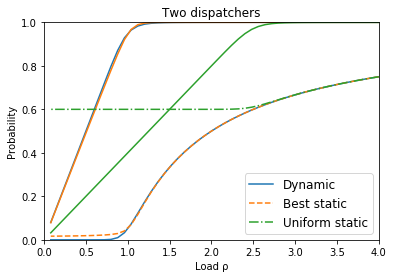

In [27]:
# plot
plot(ρρ, dynamic, color = 'C0', label = "Dynamic")
plot(ρρ, ρρ * [1. - β for β in dynamic], color = 'C0')
plot(ρρ, best_static, '--', color = 'C1', label = "Best static")
plot(ρρ, ρρ * [1. - β for β in best_static], color = 'C1')
plot(ρρ, uniform_static, '-.', color = 'C2', label = 'Uniform static')
plot(ρρ, ρρ * [1. - β for β in uniform_static], color = 'C2')

#ρρρ, exp_blocking \
#= loadtxt('data/dispatchers' + str(l) + '-hete-dynamic-blocking', delimiter='\t', unpack=True)
#plot(ρρρ, exp_blocking, color = 'C0', linestyle="None", marker="x", label="Dynamic")

#ρρρ, exp_blocking \
#= loadtxt('data/dispatchers' + str(l) + '-hete-best_static-blocking', delimiter='\t', unpack=True)
#plot(ρρρ, exp_blocking, color = 'C1', linestyle="None", marker="+", label="Best static")

#ρρρ, exp_blocking \
#= loadtxt('data/dispatchers' + str(l) + '-hete-uniform_static-blocking', delimiter='\t', unpack=True)
#plot(ρρρ, exp_blocking, color = 'C2', linestyle="None", marker="x", label="uniform_static static")

xlim(0,4); ylim(0,1)
legend(loc=4); title("Two dispatchers")
xlabel("Load ρ"); ylabel("Probability")
show()

In [28]:
# save
df = pd.DataFrame({'rho': ρρ,
                    'db': dynamic,
                    'do': ρρ * [1. - β for β in dynamic],
                    'ob': best_static,
                    'oo': ρρ * [1. - β for β in best_static],
                    'ub': uniform_static,
                    'uo': ρρ * [1. - β for β in uniform_static]
                    })

fn = "data/theo-jiq-comp.csv"
df.to_csv(fn, index = False)